# Recommendation for Restaurants along HK MTR Stations

In [674]:
# import packages
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from opencage.geocoder import OpenCageGeocode
import numpy as np
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import json 
import sys
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
sns.set(color_codes=True)
%matplotlib inline

In [680]:
# preparing for data
df=pd.read_csv("hongkongmtr.csv") #download from wiki #cannot retrieve data thru api due to the location (China)
df.head()

,MTR Station,Chinese
0,Admiralty Station,金鐘
1,Airport Station,機場
2,AsiaWorld-Expo Station,博覽館
3,Austin Station,柯士甸
4,Causeway Bay Station,銅鑼灣


In [796]:
###### get geographic data

key = '' #confidential
geocoder = OpenCageGeocode(key)
adict={}

for i in list(df['MTR Station']):
    
    address = i + ', Hong Kong, PRC'
    location = geocoder.geocode(address)[0]
    info = location['geometry']    
    try:
        info['region']=location['components']['region']
    except KeyError:
        info['region']= np.nan
    try:
        info['county']=location['components']['county']
    except KeyError:
        info['county']=np.nan
        
    adict[i]=info
    
latlng=pd.DataFrame.from_dict(adict,orient='index').reset_index()
latlng.columns=['MTR Station','latitude','longitude','region','county']

df1=pd.merge(df,latlng,how='left', on=['MTR Station'])

###### make regions representations consistent

bdict={'Hong Kong':'Hong Kong Island','NT':'New Territories'}
df1=df1.replace({'region':bdict})

df1.groupby(['region','county'])['MTR Station'].count()

region            county                      
Hong Kong Island  Central and Western District     4
                  Eastern District                 8
                  Wan Chai District                3
Kowloon           Kowloon City District            2
                  Kwun Tong District               6
                  Sham Shui Po District            6
                  Wong Tai Sin District            3
                  Yau Tsim Mong District          10
New Territories   Islands District                 4
                  Kwai Tsing District              5
                  North District                   2
                  Sai Kung District                5
                  Sha Tin District                11
                  Tai Po District                  3
                  Tsuen Wan District               4
                  Tuen Mun District                2
                  Yuen Long District               5
Name: MTR Station, dtype: int64

# Map initialization

In [117]:
###### map the MTR Stations
hk_latitude = 22.350627; hk_longitude = 114.1849161
map_hk = folium.Map(location = [hk_latitude, hk_longitude], zoom_start = 10.7)

# add markers to map
for lat, lng, station,chinese,county,region in zip(df1['latitude'], 
                                            df1['longitude'], 
                                            df1['MTR Station'], 
                                            df1['Chinese'],
                                            df1['county'],
                                            df1['region']):
    label = '{},{},{}'.format(station,
                              chinese,
                              county,
                              region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_hk)  

map_hk

# Get Venues

In [118]:
###### set up foursquare API
CLIENT_ID = '' # confidential
CLIENT_SECRET= '' # confidential
VERSION = '20191201'
radius=500
LIMIT=80
lat=22.278321
lng=114.165002

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lat, 
    lng, 
    radius, 
    LIMIT)

# make the GET request
results = requests.get(url).json()["response"]['groups'][0]['items']


[{'reasons': {'count': 0,
   'items': [{'summary': 'This spot is popular',
     'type': 'general',
     'reasonName': 'globalInteractionReason'}]},
  'venue': {'id': '4b064089f964a52016ea22e3',
   'name': 'The Upper House (奕居)',
   'location': {'address': 'Pacific Place, 88 Queensway',
    'lat': 22.2774985,
    'lng': 114.1663225,
    'labeledLatLngs': [{'label': 'display',
      'lat': 22.2774985,
      'lng': 114.1663225}],
    'distance': 163,
    'cc': 'HK',
    'neighborhood': 'Admiralty',
    'city': '中環',
    'state': '中西區',
    'country': '香港',
    'formattedAddress': ['Pacific Place, 88 Queensway', '中西區', '香港']},
   'categories': [{'id': '4bf58dd8d48988d1fa931735',
     'name': 'Hotel',
     'pluralName': 'Hotels',
     'shortName': 'Hotel',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_',
      'suffix': '.png'},
     'primary': True}],
   'photos': {'count': 0, 'groups': []}},
  'referralId': 'e-0-4b064089f964a52016ea22e3-0'},
 {'reasons': {'c

In [633]:
###### get Nearby Venues
def getNearbyVenues(names, latitudes, longitudes, radius=2000,Limit=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#         print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, v['venue']['name'], 
            v['venue']['location']['lat'], v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['MTR Station', 'Neighborhood Latitude', 'Neighborhood Longitude', 
                  'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    return(nearby_venues)

hk_venues = getNearbyVenues(names=df1['MTR Station'],latitudes=df1['latitude'],longitudes=df1['longitude'])
print(hk_venues.shape)
hk_venues.head()

(3968, 7)


,MTR Station,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Admiralty Station,22.278321,114.165002,The Upper House (奕居),22.277499,114.166323,Hotel
1,Admiralty Station,22.278321,114.165002,The Asia Society Hong Kong Center (亞洲協會香港中心),22.276141,114.165263,Non-Profit
2,Admiralty Station,22.278321,114.165002,Café Gray Deluxe,22.277506,114.166320,Café
3,Admiralty Station,22.278321,114.165002,Island Shangri-La (港島香格里拉大酒店),22.277193,114.164310,Hotel
4,Admiralty Station,22.278321,114.165002,AMC Pacific Place,22.277958,114.165926,Multiplex


In [423]:
###### save data
hk_venues.to_csv('venues.csv')

In [426]:
###### get the data of all categories to define if it's a food venue
url_cate= url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
# res_cate = requests.get(url_cate).json()

cdict=[]
ddict=[]
for level1 in res_cate['response']['categories']:
    for level2 in level1['categories']:
        cdict.append([level1['name'],level2['name']])
        if len(level2['categories'])>0:
            for level3 in level2['categories']:
                ddict.append([level2['name'],level3['name']])
                
cdf=pd.DataFrame(cdict,columns=['level1','level2'])
ddf=pd.DataFrame(ddict,columns=['level2','level3'])
catedf=pd.merge(cdf,ddf,on='level2',how='outer')
catedf.to_csv('category.csv')

In [746]:
hk_venues1 = pd.merge(hk_venues, 
                  catedf[['level2', 'level3']],
                  left_on='Venue Category',
                  right_on='level3',
                  how='left')
hk_venues1.loc[hk_venues1['level2'].isna(),'level2']=hk_venues1['Venue Category']
hk_venues1=hk_venues1.drop(columns=['level3'])
hk_venues1=hk_venues1.rename(columns={
    'Venue Category':'Venue Category_temp',
    'level2':'Venue Category'
})
hk_venues1.head()

,MTR Station,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category_temp,Venue Category
0,Admiralty Station,22.278321,114.165002,The Upper House (奕居),22.277499,114.166323,Hotel,Hotel
1,Admiralty Station,22.278321,114.165002,The Asia Society Hong Kong Center (亞洲協會香港中心),22.276141,114.165263,Non-Profit,Non-Profit
2,Admiralty Station,22.278321,114.165002,Café Gray Deluxe,22.277506,114.166320,Café,Café
3,Admiralty Station,22.278321,114.165002,Island Shangri-La (港島香格里拉大酒店),22.277193,114.164310,Hotel,Hotel
4,Admiralty Station,22.278321,114.165002,AMC Pacific Place,22.277958,114.165926,Multiplex,Movie Theater


In [747]:
###### filter the different venue category to remain only 2nd level categories
hk_venues1=pd.merge(hk_venues1,catedf[['level1', 'level2']],
         left_on='Venue Category',
                  right_on='level2',
                  how='left')
hk_venues2=hk_venues1.drop(columns=['level1','level2','Venue Category_temp'])
hk_venues2=hk_venues2.drop_duplicates(keep=False)

In [809]:
hk_venues2.groupby("Venue Category")['Venue'].count().nlargest(20)

Venue Category
Café                             391
Cantonese Restaurant             314
Fast Food Restaurant             159
Sushi Restaurant                  56
Seafood Restaurant                48
Bakery                            47
Dumpling Restaurant               43
Snack Place                       39
Vegetarian / Vegan Restaurant     31
Pizza Place                       29
Ramen Restaurant                  29
Shanghai Restaurant               29
Taiwanese Restaurant              25
BBQ Joint                         23
Burger Joint                      21
Buffet                            19
Food Court                        17
Steakhouse                        17
Sandwich Place                    15
American Restaurant               13
Name: Venue, dtype: int64

In [805]:
hk_venues2.head()

,MTR Station,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,level1
1,Admiralty Station,22.278321,114.165002,Café Gray Deluxe,22.277506,114.166320,Café,Food
6,Admiralty Station,22.278321,114.165002,Fuel Espresso,22.277671,114.166241,Café,Food
7,Admiralty Station,22.278321,114.165002,Lobster Bar and Grill,22.277831,114.164887,Seafood Restaurant,Food
9,Admiralty Station,22.278321,114.165002,JW Café (JW咖啡室),22.277590,114.166660,Café,Food
10,Admiralty Station,22.278321,114.165002,Mandarin Grill + Bar (文華扒房＋酒吧),22.281462,114.160156,Steakhouse,Food


In [800]:
map_hk = folium.Map(location = [hk_latitude, hk_longitude], zoom_start = 10.7)

# add markers to map
for lat, lng, station,venue in zip(hk_venues2['Venue Latitude'], 
                                           hk_venues2['Venue Longitude'], 
                                            hk_venues2['MTR Station'], 
                                            hk_venues2['Venue']):
    label = '{},{}'.format(station,
                              venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_hk)  

map_hk

In [750]:
###### select only in food subsidiary records
hk_venues2=pd.merge(hk_venues2,dff,on='Venue Category',how='left')
hk_venues2=hk_venues2[hk_venues2['level1']=='Food']

###### drop stations with too few records/outliers

# count=hk_venues2.groupby('MTR Station')[['MTR Station','Venue Category']].count().sort_values(by='Venue Category', ascending=True)
# countt=count[count['Venue Category']<8]['Venue Category']
# print(countt)
blist=['Kam Sheung Road Station']
hk_venues2=hk_venues2[~hk_venues2['MTR Station'].isin(blist)]

In [751]:
hk_venues2.shape

(1527, 8)

In [777]:
###### replace values with unclear meanings that may affect the results

dictt={"Bus Stop":"Bus Station",
     "Coffee Shop":"Café",
      "Cha Chaan Teng":"Cantonese Restaurant" \
       ,'Hong Kong Restaurant':"Cantonese Restaurant"\
       ,'Dim Sum Restaurant':"Cantonese Restaurant"
      }
hk_venues2=hk_venues2.replace({"Venue Category": dictt})
hk_venues2=hk_venues2[hk_venues2['Venue Category']!="Restaurant"]

In [778]:
hk_venues2['Venue Category'].value_counts()

Café                             391
Cantonese Restaurant             314
Fast Food Restaurant             159
Sushi Restaurant                  56
Seafood Restaurant                48
Bakery                            47
Dumpling Restaurant               43
Snack Place                       39
Vegetarian / Vegan Restaurant     31
Pizza Place                       29
Shanghai Restaurant               29
Ramen Restaurant                  29
Taiwanese Restaurant              25
BBQ Joint                         23
Burger Joint                      21
Buffet                            19
Food Court                        17
Steakhouse                        17
Sandwich Place                    15
American Restaurant               13
Halal Restaurant                  10
Yunnan Restaurant                 10
Bubble Tea Shop                    9
Szechuan Restaurant                9
Bistro                             8
Beijing Restaurant                 7
Diner                              6
U

In [765]:
print(len(hk_venues['Venue Category'].unique()))
print(len(hk_venues2['Venue Category'].unique()))
print(hk_venues2.shape)

228
55
(1503, 8)


# Level 2 venue category - used for classification

In [779]:
# one hot encoding
hk_onehot = pd.get_dummies(hk_venues2[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
hk_onehot['Neighborhood'] = hk_venues2['MTR Station'] 

# move neighborhood column to the first column
columns = hk_onehot.columns.values.tolist()
columns.sort(key = 'Neighborhood'.__eq__)
hk_onehot = hk_onehot[columns]

hk_grouped = hk_onehot.groupby('Neighborhood').sum().reset_index()
hk_grouped.head()

,Neighborhood,American Restaurant,Australian Restaurant,BBQ Joint,Bakery,Beijing Restaurant,Bistro,Bubble Tea Shop,Buffet,Burger Joint,...,Snack Place,Steakhouse,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tea Room,Udon Restaurant,Vegetarian / Vegan Restaurant,Yunnan Restaurant
0,Admiralty Station,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,Airport Station,1,0,0,3,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,AsiaWorld-Expo Station,1,0,0,3,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Austin Station,0,0,0,0,0,0,0,1,0,...,1,0,1,0,0,0,0,0,0,0
4,Causeway Bay Station,0,0,0,1,0,0,1,0,0,...,1,0,2,0,0,0,0,0,0,0


In [780]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [781]:
num_top_venues = 8

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = hk_grouped['Neighborhood']

for ind in np.arange(hk_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hk_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,Admiralty Station,Café,Cantonese Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,Bakery,Steakhouse,Comfort Food Restaurant,Food Court
1,Airport Station,Bakery,Café,Yunnan Restaurant,Pizza Place,Bistro,Cantonese Restaurant,Chinese Aristocrat Restaurant,Deli / Bodega
2,AsiaWorld-Expo Station,Bakery,Café,Yunnan Restaurant,Pizza Place,Bistro,Cantonese Restaurant,Chinese Aristocrat Restaurant,Deli / Bodega
3,Austin Station,Café,Dumpling Restaurant,Cantonese Restaurant,Sandwich Place,Snack Place,Seafood Restaurant,Shaanxi Restaurant,Buffet
4,Causeway Bay Station,Café,Cantonese Restaurant,Sushi Restaurant,Shanghai Restaurant,Snack Place,Bubble Tea Shop,Dumpling Restaurant,Bakery


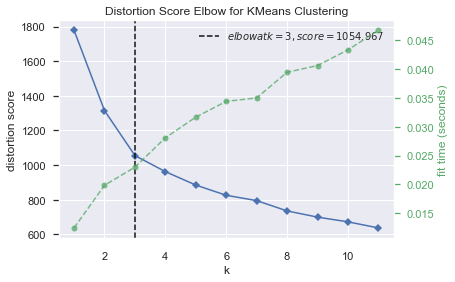

In [782]:
###### select K clusters
from yellowbrick.cluster import KElbowVisual4izer
visualizer = KElbowVisualizer(kmeans, k=(1, 12), metric='distortion')
visualizer.fit(hk_grouped_clustering)        
visualizer.show()

###### the cluster should be 3

In [783]:
# set number of clusters
kclusters = 3

hk_grouped_clustering = hk_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=1,).fit(hk_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_
#len(kmeans.labels_)#=16
hk_merged = neighborhoods_venues_sorted

# add clustering labels
hk_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
hk_merged = pd.merge(df1, hk_merged,left_on='MTR Station',right_on='Neighborhood')
hk_merged.groupby('Cluster Labels')['MTR Station'].count()

Cluster Labels
0    25
1    35
2    22
Name: MTR Station, dtype: int64

In [784]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location = [hk_latitude, hk_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
# color = [colors.rgb2hex(i) for i in colors_array]
color=['red','green','black','blue']


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hk_merged['latitude'], hk_merged['longitude'], hk_merged['Neighborhood'], hk_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=color[cluster-1],
        fill=True,
        fill_color=color[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

# see what's inside each cluster

In [788]:
grouped = hk_merged[['Neighborhood',
                     'Cluster Labels',
                     '1st Most Common Venue', 
                     '2nd Most Common Venue', 
                     '3rd Most Common Venue',
                     '4th Most Common Venue',
                     '5th Most Common Venue','6th Most Common Venue','7th Most'
                    ]]

grouped.loc[:, 'Top Venues'] = grouped.apply(lambda x: ", ".join(x.iloc[2:5]), axis=1)
grouped = grouped.drop(['1st Most Common Venue', 
                        '2nd Most Common Venue', 
                        '3rd Most Common Venue',
                     '4th Most Common Venue',
                     '5th Most Common Venue','6th Most Common Venue'], axis=1)
def mix(group):
    return ', '.join(group['Top Venues'].tolist())
top_venues = grouped.groupby('Cluster Labels').apply(mix)

c0dist = grouped.groupby('Cluster Labels').get_group(0).shape[0]
clr0 = pd.Series(top_venues[0].split(', '), name='Cluster 0').value_counts().nlargest(5)/c0dist
c1dist = grouped.groupby('Cluster Labels').get_group(1).shape[0]
clr1 = pd.Series(top_venues[1].split(', '), name='Cluster 1').value_counts().nlargest(5)/c1dist
c2dist = grouped.groupby('Cluster Labels').get_group(2).shape[0]
clr2 = pd.Series(top_venues[2].split(', '), name='Cluster 2').value_counts().nlargest(5)/c2dist
# c3dist = grouped.groupby('Cluster Labels').get_group(3).shape[0]
# clr3 = pd.Series(top_venues[3].split(', '), name='Cluster 3').value_counts().nlargest(5)/c3dist

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

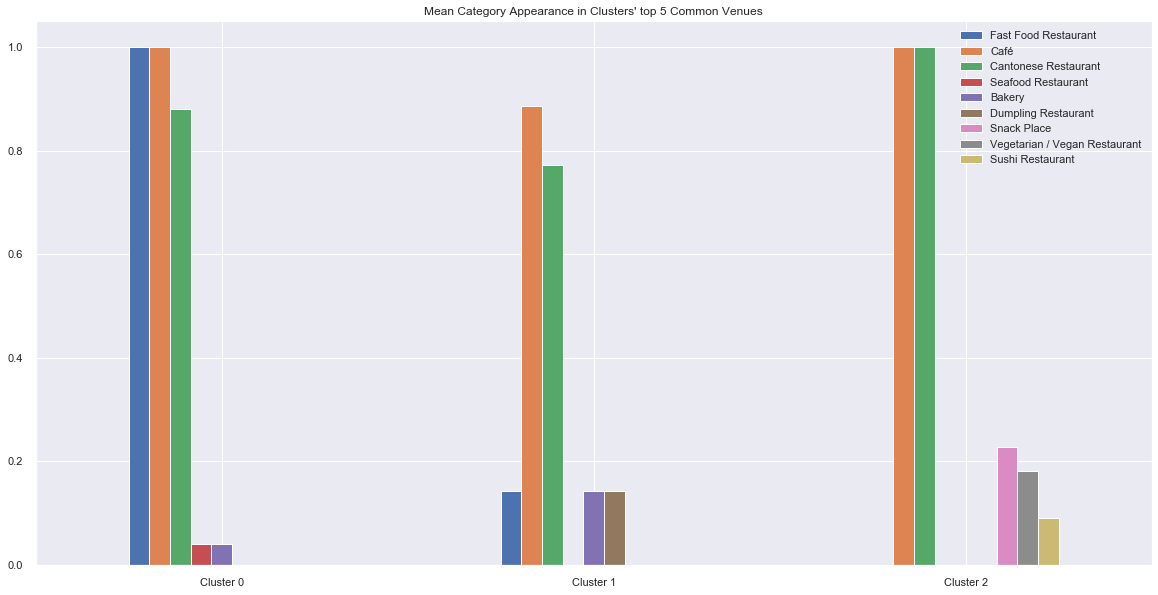

In [810]:
ax = pd.concat([clr0,clr1,clr2], sort=False, axis=1).transpose().plot(kind='bar', figsize=(20, 10))
plt.title("Mean Category Appearance in Clusters' top 5 Common Venues") 
plt.xticks(rotation=0)

# Results

In [811]:
###### Cluster 0: Much coffee, much cantonese restaurant, some dumpling and bakery
print("cluster0: Very much coffee, very much fastfood, much cantonese restaurant \n\n",
      [(x,y) for x, y in zip(hk_merged[hk_merged['Cluster Labels']==0]['MTR Station'],
                                       hk_merged[hk_merged['Cluster Labels']==0]['Chinese'])])

###### Cluster 1:Very much coffee, very much fastfood, much cantonese restaurant, not much coffee
print("\ncluster1: Much coffee, much cantonese restaurant, some fast food, dumpling, bakery \n\n",
      [(x,y) for x, y in zip(hk_merged[hk_merged['Cluster Labels']==1]['MTR Station'],
                                       hk_merged[hk_merged['Cluster Labels']==1]['Chinese'])])

###### Cluster 2:Very much coffee, very much cantonese restaurant, some seafood and some american(pressure, little time&money for some real food)
print("\ncluster2: Very much coffee, very much cantonese , some snack,vegan and sushi,no fastfood \n\n",
      [(x,y) for x, y in zip(hk_merged[hk_merged['Cluster Labels']==2]['MTR Station'],
                                       hk_merged[hk_merged['Cluster Labels']==2]['Chinese'])])

print("\nwow HKers do drink a lot of coffee, so much pressure")

cluster0: Very much coffee, very much fastfood, much cantonese restaurant 

 [('Chai Wan Station', '柴灣'), ('Choi Hung Station', '彩虹'), ('Fanling Station', '粉嶺'), ('Hang Hau Station', '坑口'), ('Heng On Station', '恆安'), ('Kwai Fong Station', '葵芳'), ('Kwai Hing Station', '葵興'), ('Lai King Station', '荔景'), ('Lo Wu Station', '羅湖'), ('Long Ping Station', '朗屏'), ('Mei Foo Station', '美孚'), ('Po Lam Station', '寶琳'), ('Racecourse Station', '馬場'), ('Shek Mun Station', '石門'), ('Siu Hong Station', '兆康'), ('Tai Po Market Station', '大埔墟'), ('Tai Wo Station', '太和'), ('Tin Shui Wai Station', '天水圍'), ('Tiu Keng Leng Station', '調景嶺'), ('Tseung Kwan O Station', '將軍澳'), ('Tuen Mun Station', '屯門'), ('University Station', '大學'), ('Wu Kai Sha Station', '烏溪沙'), ('Yau Tong Station', '油塘'), ('Yuen Long Station', '元朗')]

cluster1: Much coffee, much cantonese restaurant, some fast food, dumpling, bakery 

 [('Admiralty Station', '金鐘'), ('Airport Station', '機場'), ('AsiaWorld-Expo Station', '博覽館'), ('Austin Station',